In [32]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,classification_report,recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,StackingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import joblib
from sqlalchemy import create_engine

In [33]:
import warnings
warnings.filterwarnings("ignore")

In [34]:
username = 'root'
password = 'yashish2003'
host = 'localhost'
port = 3306
database = 'spam_detection'

In [35]:
engine = create_engine(f"mysql+pymysql://{username}:{password}@{host}:{port}/{database}")

query = "SELECT * FROM dataset"

In [36]:
df = pd.read_sql(query, engine)
df.head(10)

,category,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [37]:
df = df.where(pd.notnull(df))

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5562 entries, 0 to 5561
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  5562 non-null   object
 1   message   5562 non-null   object
dtypes: object(2)
memory usage: 87.0+ KB


In [39]:
ham = df[df['category'] == 'ham']
spam = df[df['category'] == 'spam']

ham_count = ham['category'].count()
spam_count = spam['category'].count()

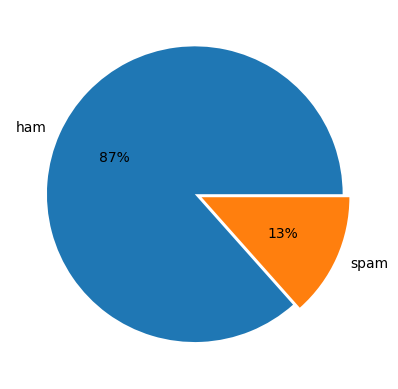

In [40]:
data = [ham_count,spam_count]
labels = ['ham','spam']
plt.pie(data,labels=labels,explode=[0,0.05],autopct='%.0f%%')

plt.show()

In [41]:
category_encoder = LabelEncoder()
df['category'] = category_encoder.fit_transform(df['category'])

In [42]:
df['category'].value_counts()

category
0    4815
1     747
Name: count, dtype: int64

In [43]:
df.head()

,category,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [44]:
x = df['message']
y = df['category']

In [45]:
message_encoder = TfidfVectorizer()
message_encoder.fit(df['message'])
message_encoded = message_encoder.transform(df['message'])

In [46]:
x_train,x_test,y_train,y_test = train_test_split(message_encoded,y,test_size=0.2,random_state=42)

In [47]:
x_train_ = x_train.toarray()
x_test_ = x_test.toarray()

In [48]:
base_model = [
    ('svm',SVC(random_state=42)),
    ('rf',RandomForestClassifier(random_state=42)),
    ('nb',MultinomialNB())
]

In [49]:
meta_model = LogisticRegression()

In [50]:
model = StackingClassifier(estimators=base_model,final_estimator=meta_model,cv = 4)

In [51]:
model.fit(x_train_,y_train)

StackingClassifier(cv=4,
                   estimators=[('svm', SVC(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('nb', MultinomialNB())],
                   final_estimator=LogisticRegression())

In [52]:
y_pred = model.predict(x_test_)

In [53]:
accuracy_score(y_test,y_pred)

0.9874213836477987

In [54]:
your_mail = ['You have a chance to won a prize']
your_mail_encoded = message_encoder.transform(your_mail)
your_mail_encoded = your_mail_encoded.toarray()
ans = model.predict(your_mail_encoded)

print("This is:",category_encoder.inverse_transform(ans)[0])

This is: spam


In [55]:
joblib.dump(model,'model_saved.joblib')

['model_saved.joblib']

In [56]:
joblib.dump(message_encoder,'message_encoder.joblib')

['message_encoder.joblib']